In [ ]:
import numpy as np

import matplotlib.pyplot as plt

from sklearn.gaussian_process import GaussianProcessRegressor as GPR
from sklearn.gaussian_process.kernels import Matern

import pymc3 as pm

# GP inferences: the prior

The prior $GP$ has a zero mean function and $Matern52$ covariance function with parameters $\ell = 1, \eta = 3$.

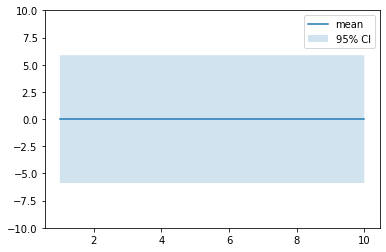

In [ ]:
xs = np.linspace(1, 10, 1000)
eta = 3
l = 1

model = GPR(eta**2 * Matern(l, nu=2.5), optimizer=None)

mean, sd = model.predict(xs.reshape(-1, 1), return_std=True)

plt.plot(xs, mean, label='mean')
plt.fill_between(
    xs, mean + 1.96 * sd, mean - 1.96 * sd, 
    alpha=.2, label='95% CI'
)

plt.ylim(-10, 10)
plt.legend()

plt.show()

# GP inferences: the posterior

Observations are randomly drawn between 1 and 10. The latent function is a variant of the Gramacy & Lee function.

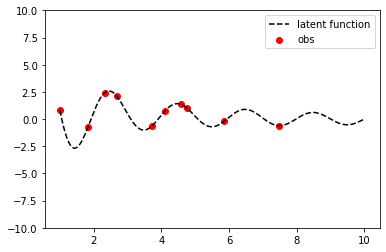

In [ ]:
def gramacy_and_lee(x):
    return 5 * np.sin(np.pi * x) / x + (x / 10 - 1) ** 2


np.random.seed(1)
X_sample = np.random.uniform(low=1, high=10, size=10).reshape(-1, 1)
Y_sample = gramacy_and_lee(X_sample)

plt.plot(xs, gramacy_and_lee(xs), c='k', linestyle='--', label='latent function')
plt.scatter(X_sample, Y_sample, c='r', label='obs')
plt.ylim(-10, 10)
plt.legend()
plt.show()

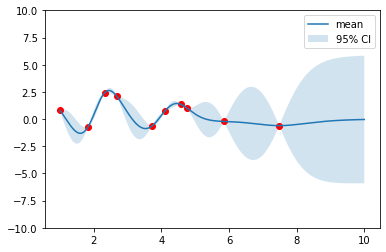

In [ ]:
model.fit(X_sample, Y_sample)
mean, sd = model.predict(xs.reshape(-1, 1), return_std=True)

plt.plot(xs, mean, label='mean')
plt.fill_between(
    xs, mean.flatten() + 1.96 * sd, mean.flatten() - 1.96 * sd, 
    alpha=.2, label='95% CI'
)

plt.scatter(X_sample, Y_sample, c='r')

plt.ylim(-10, 10)
plt.legend()

plt.show()

# GP hyper-parameters

Different value combinations of $(\ell, \eta)$ are used in `hyperparams`.

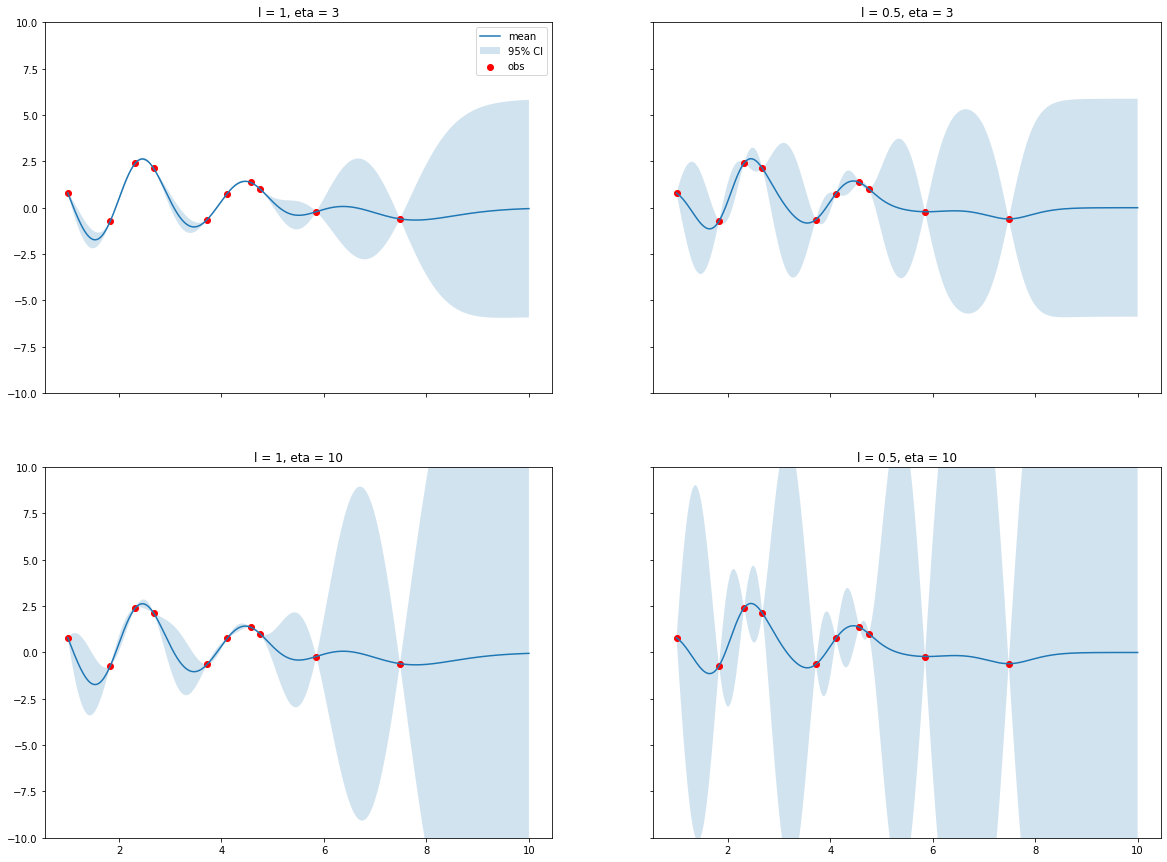

In [ ]:
hyperparams = [
    (1, 3), (0.5, 3),
    (1, 10), (0.5, 10)
]

fig, ax = plt.subplots(2, 2, figsize=(20, 15), sharex=True, sharey=True)

for i in range(4):
    tmp_ax = ax[i // 2][i % 2]
    l, eta = hyperparams[i]

    model = GPR(eta**2 * Matern(l, nu=5.2), optimizer=None)
    model.fit(X_sample, Y_sample)
    mean, sd = model.predict(xs.reshape(-1, 1), return_std=True)
    
    tmp_ax.plot(xs, mean, label='mean')
    tmp_ax.fill_between(
        xs, mean.flatten() + 1.96 * sd, mean.flatten() - 1.96 * sd, 
        alpha=.2, label='95% CI'
    )

    tmp_ax.scatter(X_sample, Y_sample, c='r', label='obs')

    tmp_ax.set_ylim(-10, 10)
    tmp_ax.set_title(f'l = {l}, eta = {eta}')

ax[0][0].legend()

plt.show()

# GPs in PyMC3

In [ ]:
with pm.Model() as model:
    l = pm.Gamma('l', alpha=2, beta=1)
    eta = pm.HalfCauchy('eta', beta=3)

    cov_func = eta ** 2 * pm.gp.cov.Matern52(1, l)
    mean_func = pm.gp.mean.Zero()
    
    gp = pm.gp.Marginal(mean_func, cov_func)
    obs = gp.marginal_likelihood('obs', X=X_sample, y=Y_sample.squeeze(), noise=0)

    map_post = pm.find_MAP()
    
    mu, var = gp.predict(xs.reshape(-1, 1), point=map_post, diag=True)
    sd = np.sqrt(var)

/usr/local/lib/python3.6/dist-packages/pymc3/tuning/starting.py:61: UserWarning: find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
  warnings.warn('find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.')
logp = -17.651, ||grad|| = 0.66123: 100%|██████████| 17/17 [00:00<00:00, 643.24it/s]  


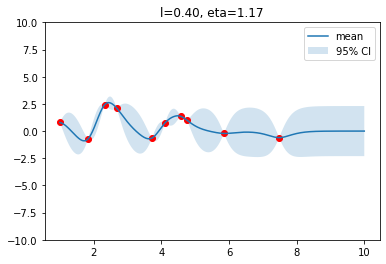

In [ ]:
plt.plot(xs, mu, label='mean')
plt.fill_between(
    xs.squeeze(), mu + 1.96 * sd, mu - 1.96 * sd, 
    label='95% CI', alpha=0.2
)
plt.title(f'l={map_post["l"]:.2f}, eta={map_post["eta"]:.2f}')

plt.scatter(X_sample, Y_sample, c='r')
plt.legend()
plt.ylim(-10, 10)
plt.show()